In [1]:
from utils import *
from model import *


# Tutorial
Сначала рассчитаем, сколько итераций требуется для сходимости сети.
Для этого есть фукнция:
find_convergence(количество node, количество edge, max_simul_steps, verbose=True, rstp=True)
Функция вовзращает:
- экземпляр класса Network, в котором хранится топология графа,
- msti2vlan маппинг msti в vlan
- region2bridge маппинг регионов на мосты
чтобы потом его можно было использовать чтобы нарисовать сеть.
- c1s - количество шагов, необходимых для сходимости деревьев
- d1s - диаметры графов


Сначала построим небольшой граф из 1 влан, 1 msti и 1 региона

In [2]:
# rstp - включить режим rstp, иначе - vanilla STP
# vlans_n - количество vlan в топологии
# regions_n - количество регионов в MST
# mystp - если True, то включается моя модифиция STP, когда порт переходит из состояния blocked
# не дожидаясь определения root bridge
# функция возвращает nets - список деревьев
# c1s - времена сходимости для каждого дерева
# d1s - диаметры деревьев

num_nodes = 3
num_edges = 3
vlans_n = 1
trees_n = 1      

regions_n = 1
max_steps = 100
params = build_graph(
    num_nodes, num_edges, vlans_n, trees_n, regions_n)

bridge2region = designate_regions(**params)
params['bridge2region'] = bridge2region
params['max_steps'] = max_steps
params['rstp'] = False
params['verbose'] = True
nets, msti2vlan, c1s, d1s = find_convergence(**params)

 14%|█▍        | 14/100 [00:00<00:00, 8116.14it/s]

STOPPED! at 14


In [3]:
params['log'] = True
nets, msti2vlan, c1s, d1s = find_convergence(**params)

 14%|█▍        | 14/100 [00:00<00:00, 3138.78it/s]

Timestep = 0
BID: 2536. Этот мост - root
-----------------------------------------------------------------
Port     Role            Status          Cost    
-----------------------------------------------------------------
0        Undesignated    Blocked         4       
1        Undesignated    Blocked         19      

Timestep = 0
BID: 110. Этот мост - root
-----------------------------------------------------------------
Port     Role            Status          Cost    
-----------------------------------------------------------------
0        Undesignated    Blocked         4       
1        Undesignated    Blocked         2       

Timestep = 0
BID: 112. Этот мост - root
-----------------------------------------------------------------
Port     Role            Status          Cost    
-----------------------------------------------------------------
0        Undesignated    Blocked         19      
1        Undesignated    Blocked         2       

Timestep = 1
BID: 2536. 
-----

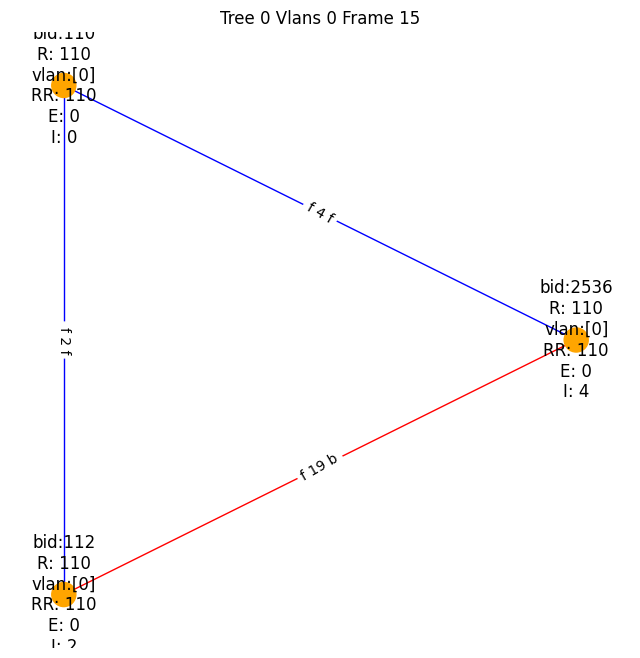

In [4]:
# Строится столько графиков, сколько trees. Каждый график сверху назван соотв.
# номером tree. Также написано, какие влан включены в данное дерево.
# Разными цветами помечены вершины, относящиеся к разным регионам
# Вершины названы след. образом:
# bid
# root_bid
# vlan (которые есть на это мосте)
# region root bid
# external_rpc
# internal_rpc
draw_stp(nets, msti2vlan, 'test-1', 15)

Получили сеть из трех мостов, все они считают root-ом 0228 (R: 110) находятся в 0 vlan, (vlan=[0]),
и поскольку на всю сеть только один регион - везде один и тот же Region Root (RR: 110).
external_rpc везде нулевая - потому что весь граф это один регион
internal_rpc - по факту соответсвует rpc в ванильном stp

In [5]:
num_nodes = 3
num_edges = 3
vlans_n = 2
trees_n = 1      

regions_n = 1
max_steps = 100
params = build_graph(
    num_nodes, num_edges, vlans_n, trees_n, regions_n)

bridge2region = designate_regions(**params)
params['bridge2region'] = bridge2region
params['max_steps'] = max_steps
params['rstp'] = False
params['verbose'] = True
nets, msti2vlan, c1s, d1s = find_convergence(**params)

 14%|█▍        | 14/100 [00:00<00:00, 5678.94it/s]

STOPPED! at 14


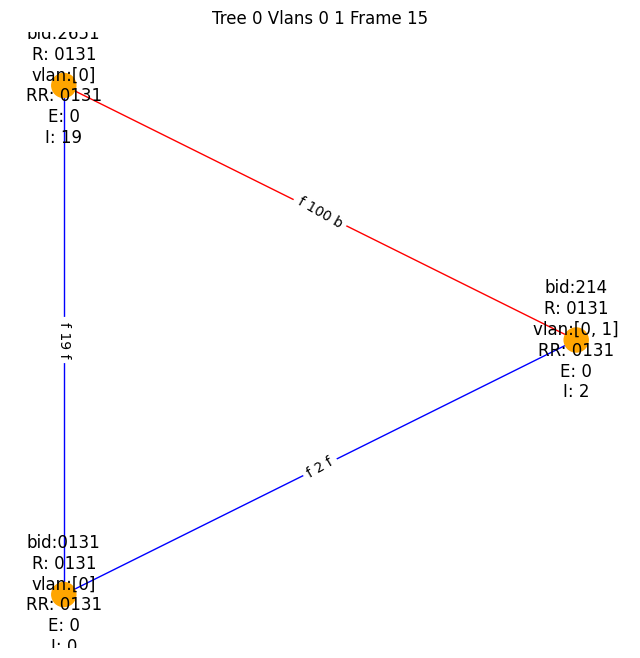

In [9]:
draw_stp(nets, msti2vlan, 'test-2', 15)

Получили ситуацию, как раньше, только некоторые мосты случайным образом назначены на некоторые vlan
(bid: 0131 находятся одновременно в [0,1] vlan), bid 0131, 2031 находится в [0] vlan

In [6]:
num_nodes = 3
num_edges = 3
vlans_n = 2
trees_n = 2  

regions_n = 1
max_steps = 100
params = build_graph(
    num_nodes, num_edges, vlans_n, trees_n, regions_n)

bridge2region = designate_regions(**params)
params['bridge2region'] = bridge2region
params['max_steps'] = max_steps
params['rstp'] = False
params['verbose'] = True
nets, msti2vlan, c1s, d1s = find_convergence(**params)

 14%|█▍        | 14/100 [00:00<00:00, 12865.96it/s]


STOPPED! at 14


 14%|█▍        | 14/100 [00:00<00:00, 10844.00it/s]

STOPPED! at 14


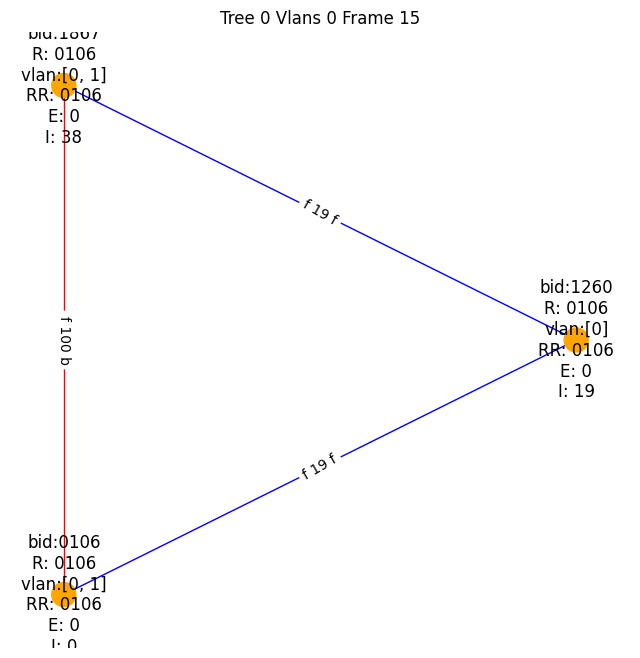

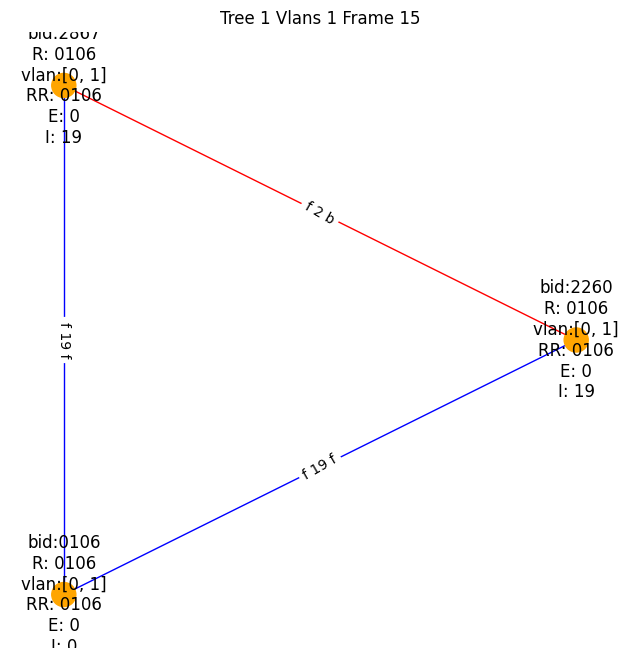

In [7]:
draw_stp(nets, msti2vlan, 'test-3', 15)

Построилось 2 msti - на каждый msti по гифке.
В верху гифки написано, какой vlan относится к msti.
Например 0ой msti относится к 0 vlan,
1ый msti - 1 vlan

# Назначим регионы вручную

Сначала построим граф, на котором будут зафиксированы mac - адреса, и дуги
приоритет пока неопределен (Х).

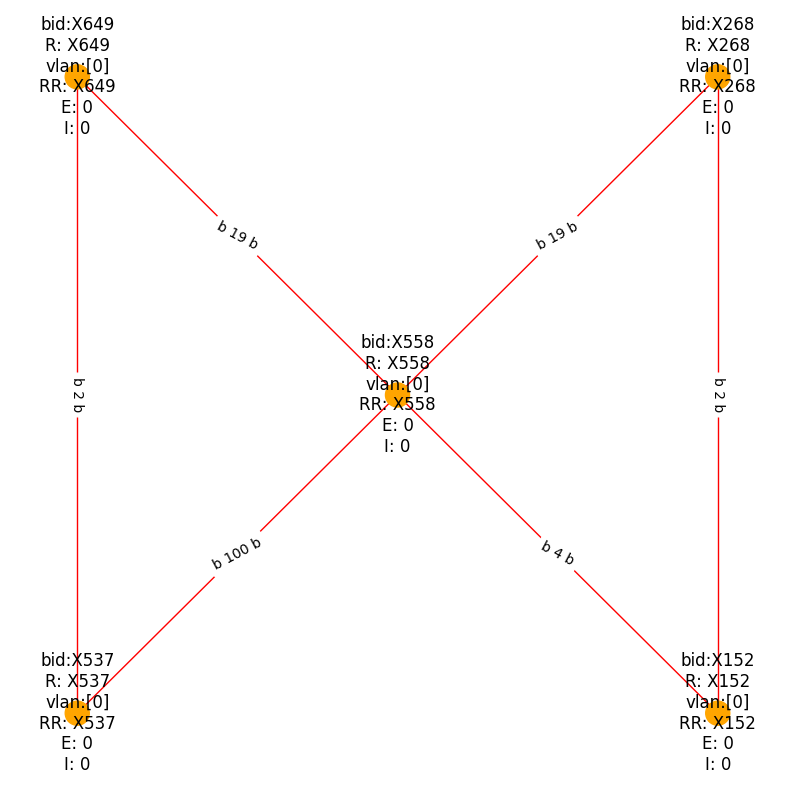

In [8]:
num_nodes = 5
num_edges = 6
vlans_n = 2
trees_n = 2  

regions_n = 2
max_steps = 100
params = build_graph(
    num_nodes, num_edges, vlans_n, trees_n, regions_n)

plot_graph(**params)

Исходя из рисунка можно понять взаимное расположение мостов, и лучшим образом организовать их в регионы.
Ниже код назначает 537, 558, 649 мосты в 1ый регион, а остальные в нулевой

In [9]:
params['bridge2region'] = {mac: 0 for _, mac in params['mac_data']}
params['bridge2region']['537'] = 1
params['bridge2region']['558'] = 1
params['bridge2region']['649'] = 1

params['bridge2region']

{'152': 0, '558': 1, '649': 1, '537': 1, '268': 0}

 14%|█▍        | 14/100 [00:00<00:00, 8528.72it/s]


STOPPED! at 14


 14%|█▍        | 14/100 [00:00<00:00, 6029.39it/s]


STOPPED! at 14


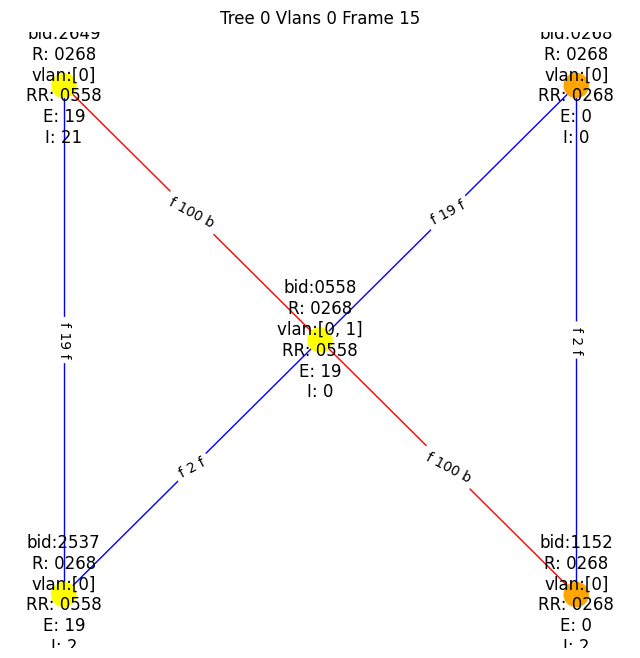

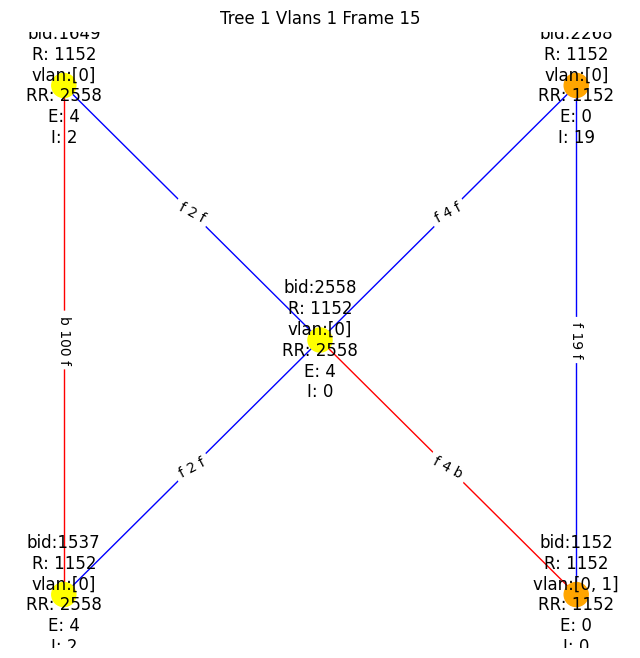

In [10]:
params['max_steps'] = max_steps
params['rstp'] = False
params['verbose'] = True
nets, msti2vlan, c1s, d1s = find_convergence(**params)
draw_stp(nets, msti2vlan, 'test-3', 15)

Видно, что нужные нам порты назначились в нужные регоны